In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load an image
img = Image.open("alpaca.jpg")
img = img.resize((224, 224))
img = np.mean(np.array(img)/255.0, axis=2)
img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()

In [3]:
# create 5x5 gaussian blur kernel
kernel = 1/256 * torch.tensor([[1,  4,  6,  4, 1],
                               [4, 16, 24, 16, 4],
                               [6, 24, 36, 24, 6],
                               [4, 16, 24, 16, 4],
                               [1,  4,  6,  4, 1]])

# use torch functional to create a gaussian blur operator
gaussian_blur = nn.Conv2d(3, 3, kernel_size=5, padding=2, bias=False)
gaussian_blur.weight.data = kernel.unsqueeze(0).unsqueeze(0)
# define transpose of Gausian blur operator
gaussian_blur_t = nn.ConvTranspose2d(3, 3, kernel_size=5, padding=2, bias=False)
gaussian_blur_t.weight.data = kernel.unsqueeze(0).unsqueeze(0)

In [4]:
# create 5x5 gaussian blur kernel
laplacian = 1/4 * torch.tensor([[0, 1,0],
                                [1,-4,1],
                                [0, 1,0]])

# use torch functional to create a laplacian operator
laplacian_filter = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
laplacian_filter.weight.data = laplacian.unsqueeze(0).unsqueeze(0)

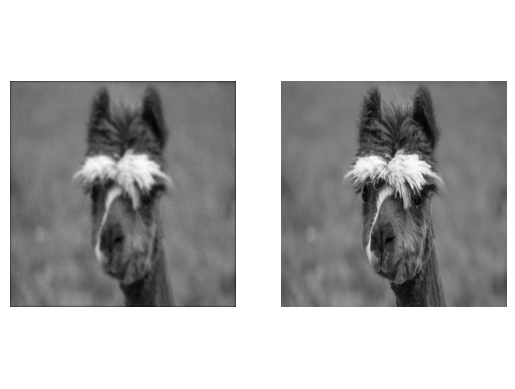

In [5]:
# apply the gaussian blur operator
img_gaussian_clean = gaussian_blur(img).detach().clone()

# add noise to the blurred image
#noise = torch.randn_like(img_gaussian_clean) * 0.02 * torch.sqrt(img_gaussian_clean)
noise = torch.randn_like(img_gaussian_clean) * 0.01
img_gaussian =img_gaussian_clean + noise

plt.subplot(1, 2, 1)
plt.imshow(img_gaussian.detach().squeeze().numpy(), cmap="gray")
plt.axis("equal")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img.detach().squeeze().numpy(), cmap="gray")
plt.axis("equal")
plt.axis("off")
plt.show()

In [6]:
alsoPlot = False
maxiter = 301
recovered = img_gaussian.detach().clone()
recovered.requires_grad = True
optimizer = torch.optim.SGD([recovered], lr=0.01, momentum = 0.8)
for i in range(maxiter):
    optimizer.zero_grad()
    loss = F.mse_loss(gaussian_blur(recovered), img_gaussian, reduction="sum") + 0.01*torch.sum(torch.abs(laplacian_filter(recovered)))
    loss.backward()
    optimizer.step()
    if i%1000==0: 
        print(loss.item())
    # visualize the recovered image every 10 iterations
    if i % 10== 0:
        if alsoPlot:
            plt.imshow(recovered.detach().squeeze().numpy(), cmap = "gray", vmin=0, vmax=1)
            plt.axis("equal")
            plt.axis("off")
            plt.show()
        #compute the psnr in comparison to the clean image
        psnr = 10 * np.log10(1 / F.mse_loss(recovered, img).item())
        print("The PSNR is ", psnr)
    

16.797056198120117
The PSNR is  30.701275574519713
The PSNR is  31.76192670682085
The PSNR is  32.58997254106761
The PSNR is  33.041536150937674
The PSNR is  33.32280727211382
The PSNR is  33.5180949468359
The PSNR is  33.662507560589404
The PSNR is  33.77469027258678
The PSNR is  33.86578579189787
The PSNR is  33.941759903653676
The PSNR is  34.00591486811335
The PSNR is  34.06153006687353
The PSNR is  34.109574745646974
The PSNR is  34.15173332373969
The PSNR is  34.18726340927612
The PSNR is  34.21901857822428
The PSNR is  34.24631023422727
The PSNR is  34.271475317064485
The PSNR is  34.29254861953273
The PSNR is  34.311523996399096
The PSNR is  34.327723868806515
The PSNR is  34.34129228614543
The PSNR is  34.35268365492047
The PSNR is  34.36275453831169
The PSNR is  34.37183979654178
The PSNR is  34.37859859698504
The PSNR is  34.3839175620348
The PSNR is  34.38870794977565
The PSNR is  34.392386224027526
The PSNR is  34.395487509036485
The PSNR is  34.397006455093944


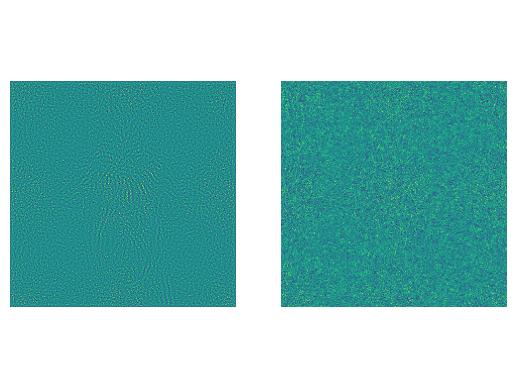

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((gaussian_blur(recovered) - img_gaussian).detach().squeeze().numpy())
ax1.axis("equal")
ax1.axis("off")

ax2.imshow((noise).detach().squeeze().numpy())
ax2.axis("equal")
ax2.axis("off")
plt.show()

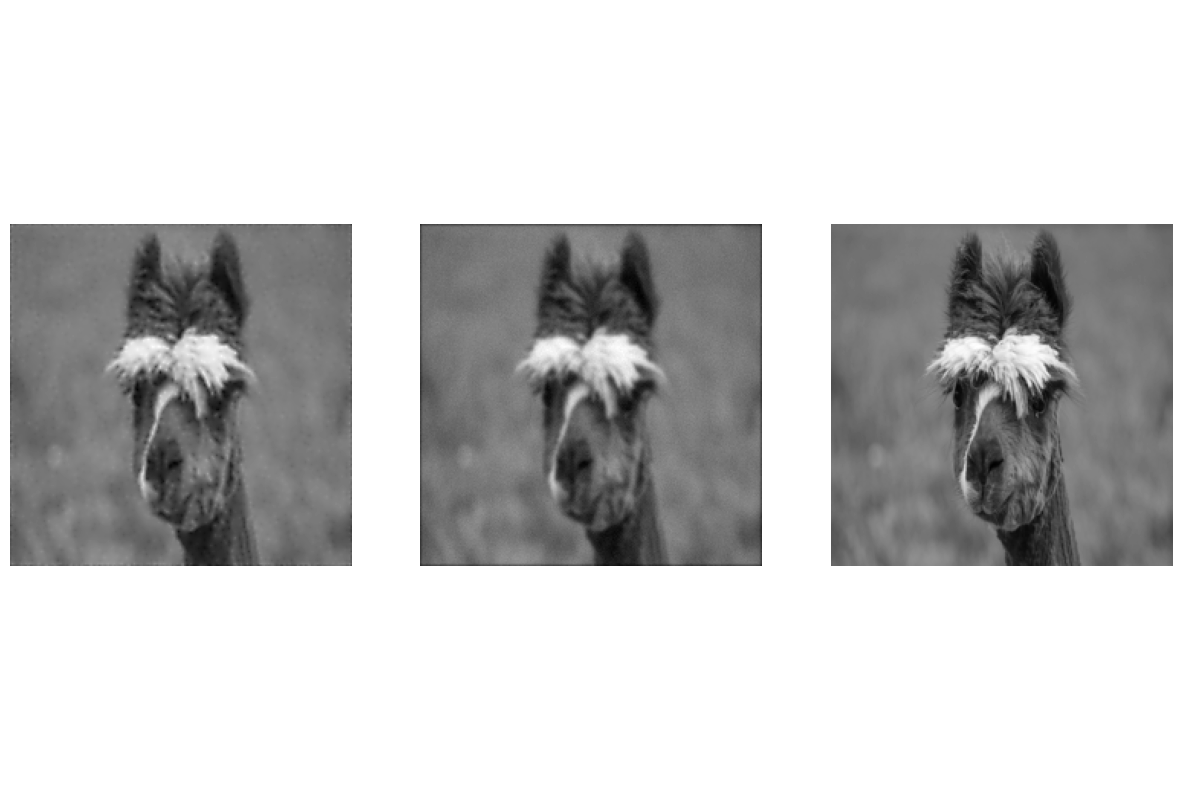

In [8]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15,10))
ax1.imshow((recovered).detach().squeeze().numpy(),cmap="gray")
ax1.axis("equal")
ax1.axis("off")

ax2.imshow((img_gaussian).detach().squeeze().numpy(),cmap="gray")
ax2.axis("equal")
ax2.axis("off")

ax3.imshow((img).detach().squeeze().numpy(),cmap="gray")
ax3.axis("equal")
ax3.axis("off")
plt.show()